In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}<style>"))

# crf

In [1]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import datetime
import random
import keras.backend as K
from keras.models import load_model
from keras.preprocessing import image
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import compute_unary, create_pairwise_bilateral, create_pairwise_gaussian, unary_from_softmax
import warnings
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
GPU_MEMORY_FRACTION = 1.0
warnings.simplefilter("ignore", np.RankWarning)

DATA_SHAPE = 224
val_images = np.load('/home/mc16/pre_data/val_image_%s.npy'%DATA_SHAPE)
val_labels = np.load('/home/mc16/pre_data/val_label_%s.npy'%DATA_SHAPE)
val_seg = np.load('/home/mc16/result/val_seg_06-14-05:52:35.npy')
test1_images = np.load('/home/mc16/pre_data/test1_image_%s.npy'%DATA_SHAPE)
test1_seg = np.load('/home/mc16/result/test1_seg_06-14-05:52:35.npy')

Using TensorFlow backend.


In [2]:
def config_keras_backend(fraction):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = fraction 
    sess = tf.Session(config=config)
    K.set_session(sess)
    
config_keras_backend(GPU_MEMORY_FRACTION)
model = load_model('/home/mc16/model3/unet_1.h5')

/home/mc16/.local/lib/python2.7/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
def crf_image(img, model, gdims=(2,3), bdims=(20,100), iteras=1):
    img = cv2.resize(img, (DATA_SHAPE, DATA_SHAPE))
    score = model.predict(np.expand_dims(img,axis=0))

    softmax = score[0].transpose((2, 0, 1)) # [channel,shap,shape]
    unary = unary_from_softmax(softmax)
    unary = np.ascontiguousarray(unary)#(2,n)
    crf = dcrf.DenseCRF(img.shape[0] * img.shape[1], 2)
    crf.setUnaryEnergy(unary)

    feats = create_pairwise_gaussian(sdims=gdims, shape=img.shape[:2])
    crf.addPairwiseEnergy(feats, compat=3, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    feats = create_pairwise_bilateral(sdims=bdims, schan=(20, 20, 20), img=img, chdim=2)
    crf.addPairwiseEnergy(feats, compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    Q = crf.inference(iteras)
    
    res = np.argmax(Q, axis=0).reshape((img.shape[0], img.shape[1]))
    return res    

def cut_shit(mask, num, frac=0.7):
    cut_mask = np.array(mask)
    for j in range(224):
        for i in range(223-num):
            if np.sum(cut_mask[j, i:i+num]) > num*frac:
                cut_L = i + int(num * (1 - frac * 0.9))
                cut_R = i + int(num * (1 - frac * 0.1))
                cut_mask[j, cut_L:cut_R] = 0
                i = cut_R
    return cut_mask

def cut_top(mask, thresh, frac=0.3):
    cut_mask = np.array(mask)
    sum_mask = np.sum(mask, axis=1)
    cut_top = 0
    for i in range(len(sum_mask)):
        if sum_mask[i] > thresh:
            cut_top = i
            break
    cut_down = cut_top + int((224 - cut_top) * frac)
#     print(cut_top, cut_down)
    cut_mask[:cut_down,:] = 0
    return cut_mask

254


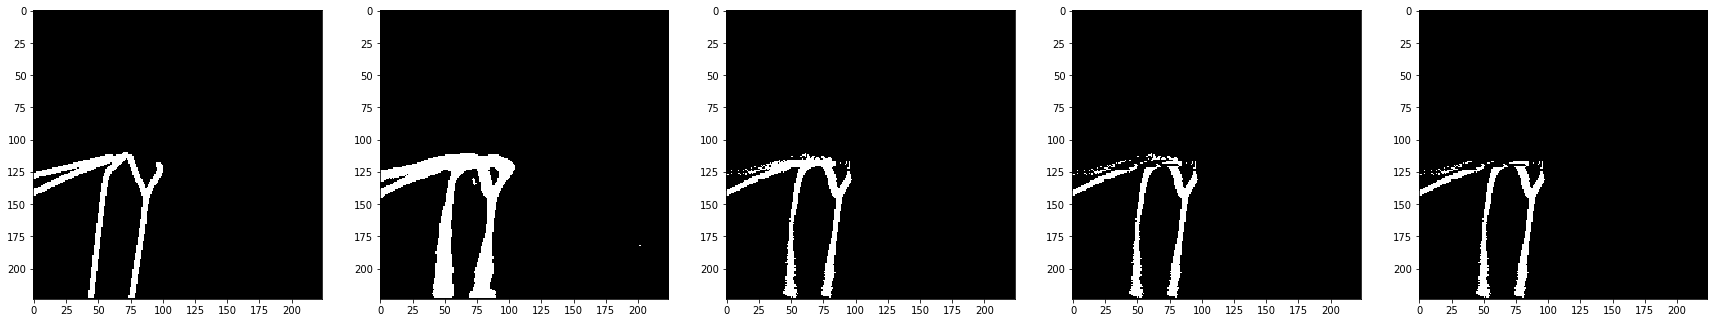

In [4]:
# CRF_GDIMS = (2, 2)
# CRF_BDIMS = (40, 30)
# CRF_ITERAS = 1
# CUT_WIDTH = 35
# CUT_FRAC = 0.8

CRF_GDIMS = (2,2)
CRF_BDIMS = (20,20)
CRF_ITERAS = 1
CUT_WIDTH = 25
CUT_FRAC = 0.75
TOP_THRESH = 10

test_index = random.randint(0, len(val_labels))
# test_index = 552
print(test_index)
test_img = val_images[test_index]
test_label = val_labels[test_index,:,:,1]
test_seg = val_seg[test_index]
test_crf = crf_image(test_img, model, gdims=CRF_GDIMS, bdims=CRF_BDIMS, iteras=CRF_ITERAS)
test_cut = cut_shit(test_crf, CUT_WIDTH, CUT_FRAC)
top_cut = cut_top(test_cut, TOP_THRESH, frac=0.04)

fig, axs = plt.subplots(1, 5, figsize=(30,30))
axs[0].imshow(test_label,cmap='gray')
axs[1].imshow(test_seg,cmap='gray')
axs[2].imshow(test_crf,cmap='gray')
axs[3].imshow(test_cut,cmap='gray')
axs[4].imshow(top_cut,cmap='gray')
plt.show()

In [5]:
def get_crf_list(image_list):
    crf_list = []
    for image in tqdm(image_list):
        crf = crf_image(image, model, gdims=CRF_GDIMS, bdims=CRF_BDIMS, iteras=CRF_ITERAS)
        cut = cut_shit(crf, CUT_WIDTH, CUT_FRAC)
        t_cut = cut_top(cut, TOP_THRESH, frac=0.04)
        crf_list.append(t_cut)
    return crf_list

def get_segcut_list(seg_list):
    sc_list = []
    for seg in tqdm(seg_list):
        cut = cut_shit(seg, CUT_WIDTH, CUT_FRAC)
        sc_list.append(cut)
    return sc_list

TIMEFORMAT = "%m-%d-%H:%M:%S"
val_crf = get_crf_list(val_images)
# val_crf = get_segcut_list(val_seg)
time = datetime.datetime.now().strftime(TIMEFORMAT)
print(time)
np.save('/home/mc16/result/val_crf_%s.npy'%time, val_crf)

100%|██████████| 2015/2015 [14:15<00:00,  2.36it/s]


06-14-06:32:46


In [28]:
test1_crf = get_crf_list(test1_images)
time = datetime.datetime.now().strftime(TIMEFORMAT)
print(time)
np.save('/home/mc16/result/test1_crf_%s.npy'%time, test1_crf)

100%|██████████| 2034/2034 [13:55<00:00,  2.44it/s]


06-14-05:39:17
